# **Kang Hyperparameter search**

In this notebook I run the hyperparameter search for the downstream analysis of sex-specific differences in the liver.


# **Imports**

In [37]:
# import the VAE code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [56]:
## parameters
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_kang_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_kang/"
cibersort_genes_path = (f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/" +
                        "CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_refsample.bm.K999.txt")

# cibersort results
cibersort_file_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/CIBERSORTx_Job18_Results.csv"

# bp results
bp_res_path = f"{os.getcwd()}/../results/single_cell_data/bp_kang/"

# DiffExp results
de_res_path = f"{os.getcwd()}/../data/single_cell_data/kang_rybakov/kang_DE_paper.tsv"

num_genes = 7000

exp_id = "mono-kang"

RETRAIN_MODELS = False

# Set-up experimental variables

In [39]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 8


# number of patients/domains/samples expected
n_tot_samples = 8 # 8 bulk and single cell samples

# number of drugs
# one-hot encoded
n_drugs = 2

# number of types of sequencing (one-hot encoded)
n_tech = 2

# experiment id
lab_file_name = exp_id


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [40]:
# read in the labeled data
X_full, Y_full, gene_df, meta_df = sc_preprocess.read_all_kang_pseudobulk_files(aug_data_path, exp_id, num_bulks_training=10)
X_full.columns = gene_df


1488
STIM
Train
Test
CTRL
Train
Test
1244
STIM
Train
Test
CTRL
Train
Test
1016
STIM
Train
Test
CTRL
Train
Test
101
STIM
Train
Test
CTRL
Train
Test
1039
STIM
Train
Test
CTRL
Train
Test
107
STIM
Train
Test
CTRL
Train
Test


In [41]:
meta_df.sample_id.value_counts()

1488    2220
1244    2220
1016    2220
101     2220
1039    2220
107     2220
1015    2000
1256    2000
Name: sample_id, dtype: int64

In [42]:
meta_df

sample_id  stim isTraining      cell_prop_type samp_type
0         1015  CTRL      Train              random    sc_ref
1         1015  CTRL      Train              random    sc_ref
2         1015  CTRL      Train              random    sc_ref
3         1015  CTRL      Train              random    sc_ref
4         1015  CTRL      Train              random    sc_ref
...        ...   ...        ...                 ...       ...
1095       107  CTRL       Test  cell_type_specific      bulk
1096       107  CTRL       Test  cell_type_specific      bulk
1097       107  CTRL       Test  cell_type_specific      bulk
1098       107  CTRL       Test  cell_type_specific      bulk
1099       107  CTRL       Test  cell_type_specific      bulk

[17320 rows x 5 columns]

In [43]:
X_full

gene_ids LINC00115 NOC2L KLHL17 PLEKHN1  HES4  ISG15 AGRN C1orf159 TNFRSF18  \
0              165   510      8      51   875  15392    0       52      405   
0              142   932      2     596   216   9662    0       44      566   
0              506  1584      0    1131    68  13818    0       86      537   
0              255  1371      0     603   402  11352    0      123     1006   
0               84  1291      4     311   486   8505    0       29      781   
..             ...   ...    ...     ...   ...    ...  ...      ...      ...   
0                0    44      0       0  1978     60    0        0     2384   
0                0    77      0       0   140     84    2        0     1811   
0                0   120      0       0   164    241    4        4     1868   
0                0   252      0       0  1044    393   21       19     1412   
0                0    45      0       0    80     66    5        4     1613   

gene_ids TNFRSF4  ... CPT1B AF127936.5 AJ006998.2 CHODL AP000476.1 LINC00158  \
0           1289  ...     0          0          0     0          0         0   
0           5343  ...     0          0          0     0          0         0   
0          13384  ...     0          0          0     0          0         0   
0           8208  ...     0          0          0     0          0         0   
0           3081  ...     0          0          0     0          0         0   
..           ...  ...   ...        ...        ...   ...        ...       ...   
0            467  ...     0          0          0     0          0         0   
0            438  ...     0          0          0     0          0         0   
0            432  ...     0          0          0     0          0         0   
0            377  ...     0          0          0     0          0         0   
0            408  ...     0          0          0     0          0         0   

gene_ids AF131217.1 AP001437.1 TMPRSS3 LRRC3DN  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
..              ...        ...     ...     ...  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  

[17320 rows x 13452 columns]

# Define indices and set-up metadata

In [44]:

##################################################
#####. Design the experiment
##################################################

X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]

# only get genes that are available in both testing and training
common_genes_file = os.path.join(aug_data_path, "kang_genes.pkl")
gene_out_path = Path(common_genes_file)
common_genes = pickle.load(open( gene_out_path, "rb" ))

# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(common_genes, cibersort_genes)

X_train_df = X_train_df[common_genes]

gene_df = gene_df.loc[gene_df.isin(common_genes)]


# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -6928)[-6928:]
gene_df = gene_df.iloc[idx_top]


# Make sure our test/train indicies are correct



In [45]:
np.unique(Bulk_full,  return_counts=True)

(array([0, 1]), array([13320,  4000]))

In [46]:
tab = meta_df.groupby(['samp_type', 'sample_id']).size()
tab.unstack()

sample_id     101    1015    1016    1039     107    1244    1256    1488
samp_type                                                                
bulk       2220.0     NaN  2220.0  2220.0  2220.0  2220.0     NaN  2220.0
sc_ref        NaN  2000.0     NaN     NaN     NaN     NaN  2000.0     NaN

In [47]:
tab = meta_df.groupby(['isTraining', 'samp_type']).size()
tab.unstack()

samp_type      bulk  sc_ref
isTraining                 
Test        13200.0     NaN
Train         120.0  4000.0

In [48]:
tab = meta_df.iloc[idx_train].groupby(['isTraining', 'stim']).size()
tab.unstack()

stim        CTRL  STIM
isTraining            
Train       4060    60

In [49]:
tab = meta_df.iloc[idx_train].groupby(['isTraining', 'samp_type']).size()
tab.unstack()

samp_type   bulk  sc_ref
isTraining              
Train        120    4000

# compare our variable genes with cibersort defined genes

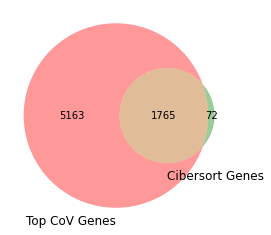

In [50]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [51]:
union_genes = np.union1d(gene_df, cibersort_genes)
len(union_genes)

7000

# Normalize data

In [52]:
X_full = X_full.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
bulk_unkp = bulk_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
bulk_kp = bulk_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()


# Plot all data

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 17320 samples in 0.075s...
[t-SNE] Computed neighbors for 17320 samples in 33.367s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17320
[t-SNE] Computed conditional probabilities for sample 2000 / 17320
[t-SNE] Computed conditional probabilities for sample 3000 / 17320
[t-SNE] Computed conditional probabilities for sample 4000 / 17320
[t-SNE] Computed conditional probabilities for sample 5000 / 17320
[t-SNE] Computed conditional probabilities for sample 6000 / 17320
[t-SNE] Computed conditional probabilities for sample 7000 / 17320
[t-SNE] Computed conditional probabilities for sample 8000 / 17320
[t-SNE] Computed conditional probabilities for sample 9000 / 17320
[t-SNE] Computed conditional probabilities for sample 10000 / 17320
[t-SNE] Computed conditional probabilities for sample 11000 / 17320
[t-SNE] Computed conditional probabilities for sample 12000 / 17320
[t-SNE] Computed conditional probabilities for sa

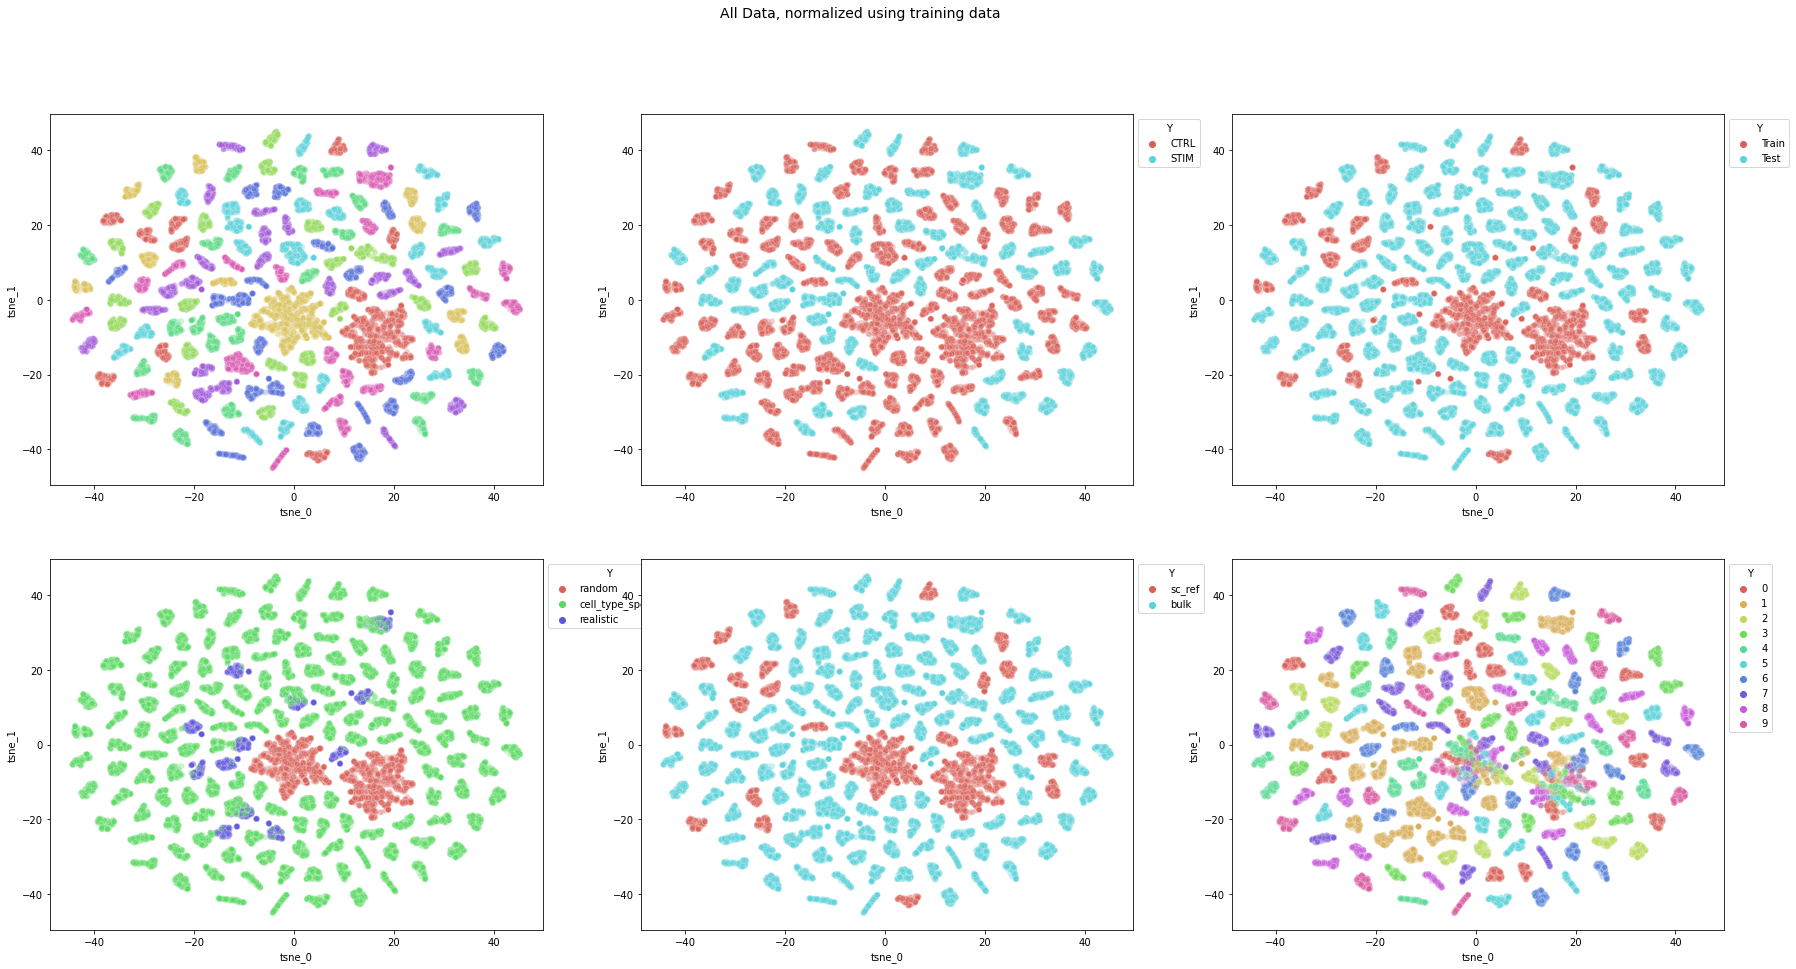

In [53]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


(120, 2)
(120, 2)


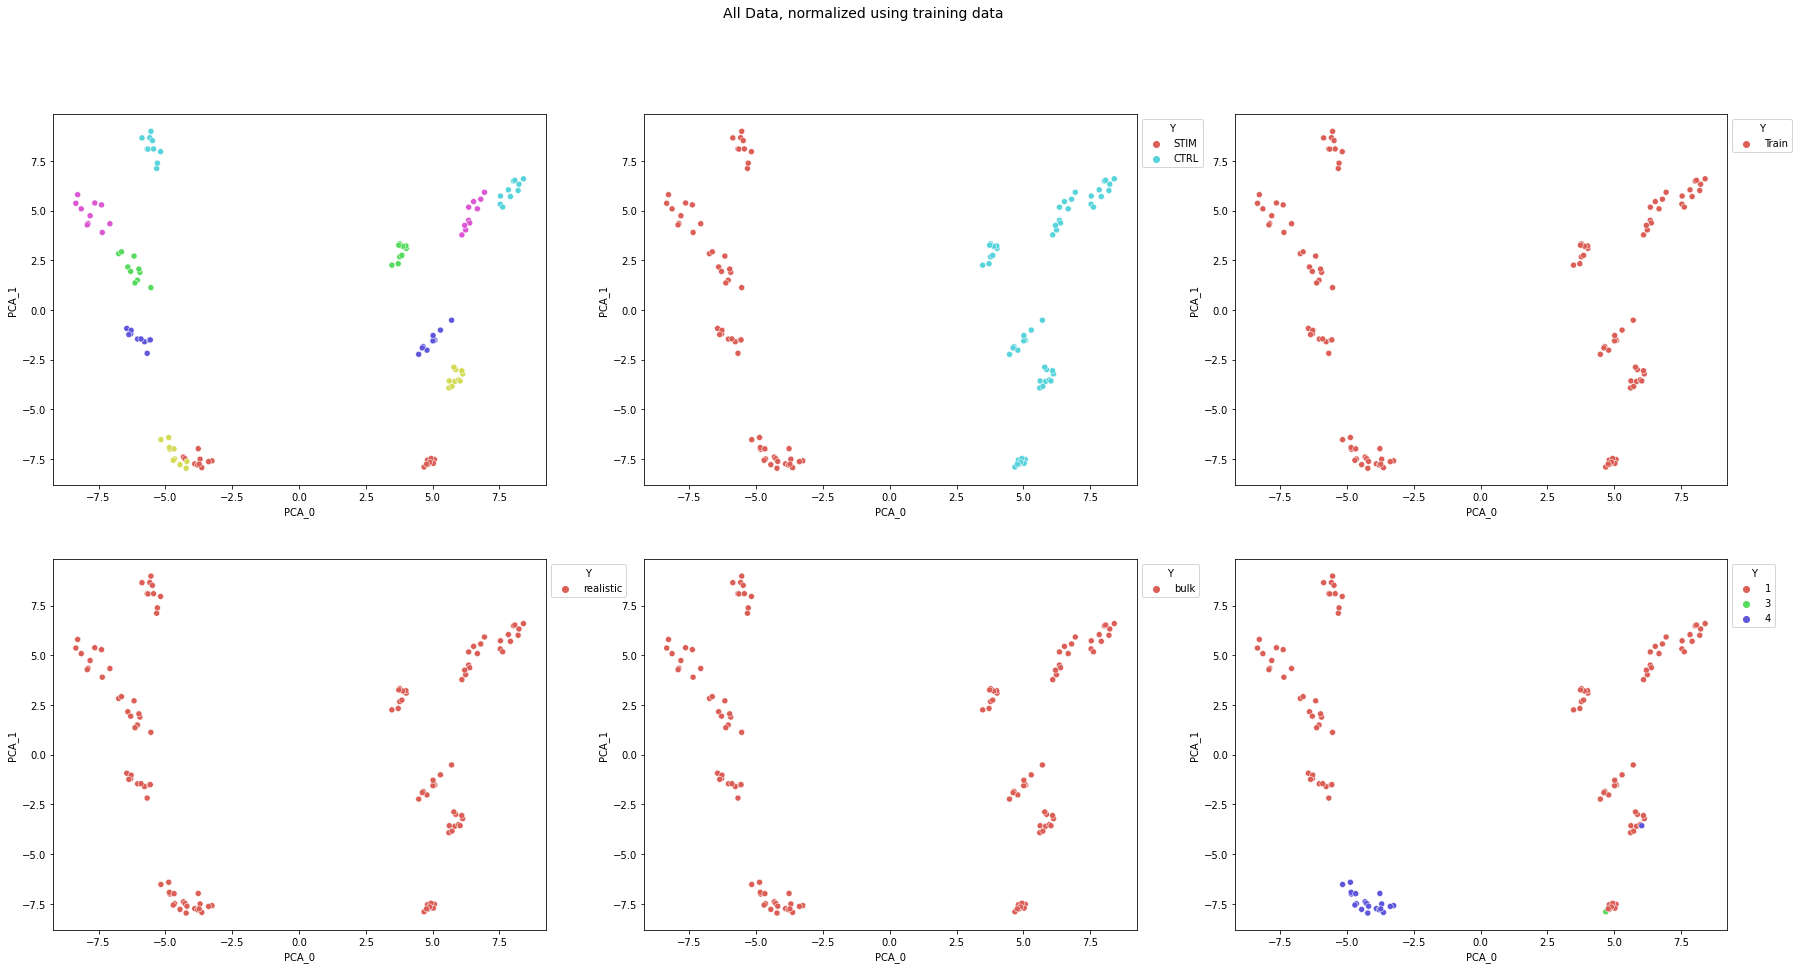

In [54]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_pca_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"", alpha=1)
vp.plot_pca(plot_df, Y_temp, axs[1,2], title=f"", alpha=1)


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.001s...
[t-SNE] Computed neighbors for 120 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 12.872424


[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.030621
[t-SNE] KL divergence after 500 iterations: 0.066069
(120, 2)
(120, 2)


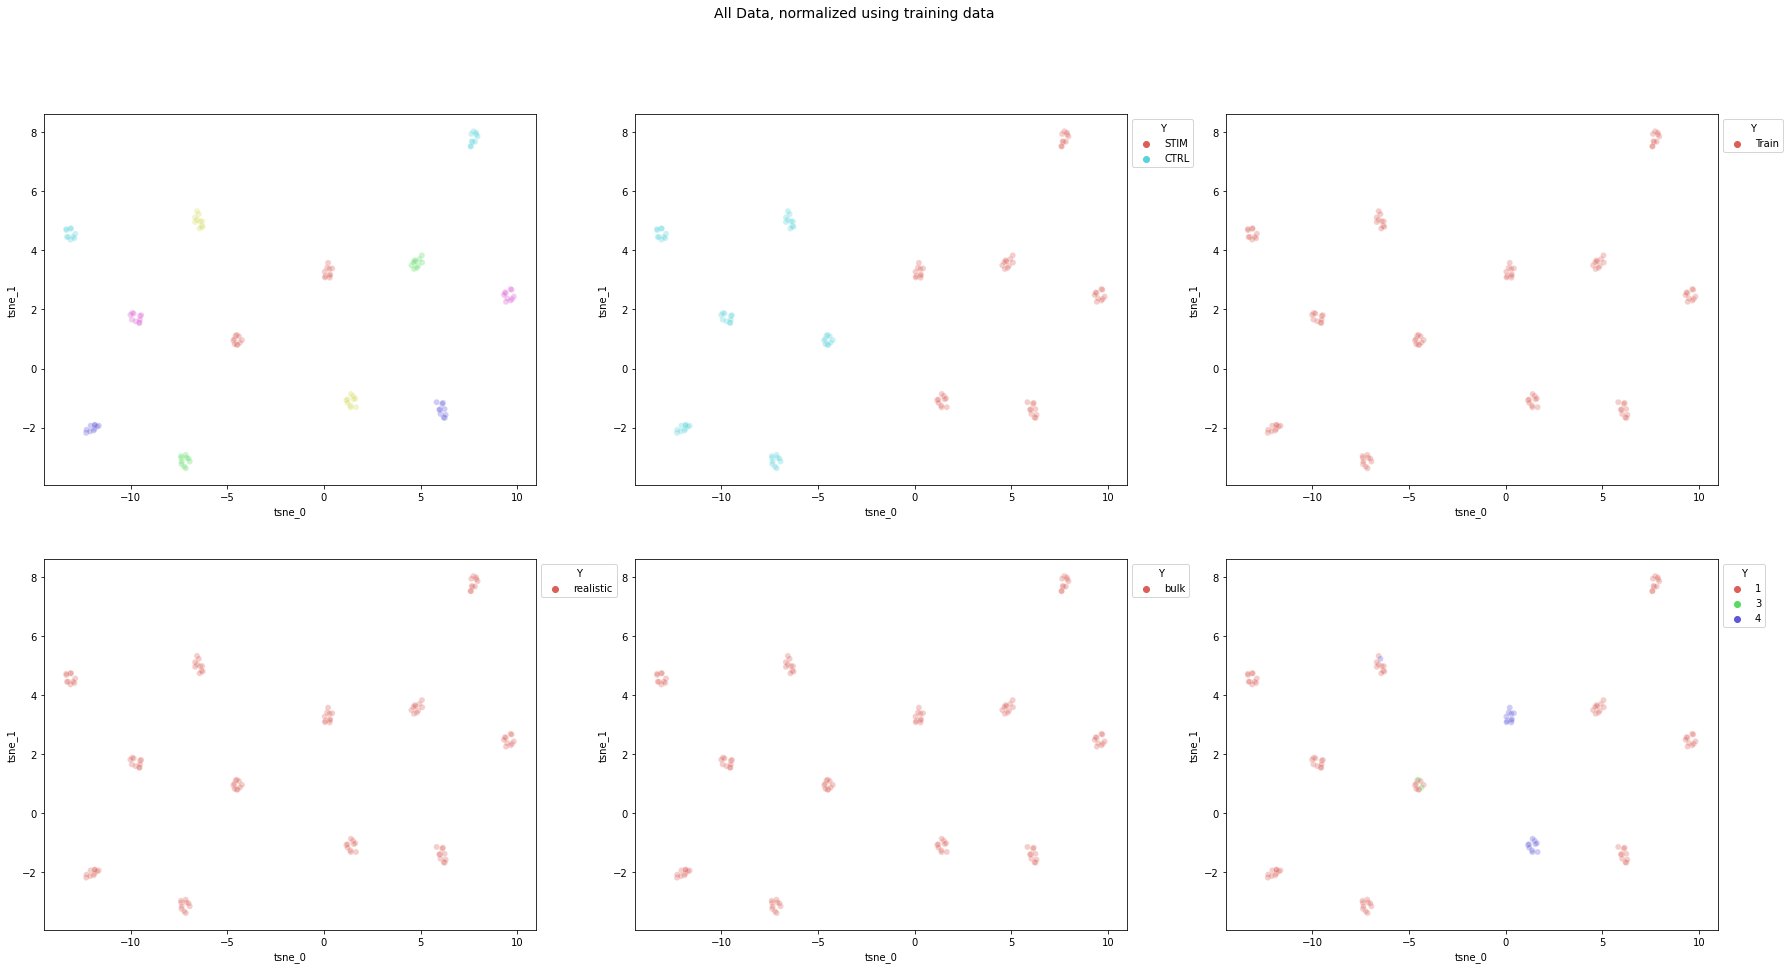

In [55]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_tsne_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **Run BuDDI**

## Hyperparameter Search

We are going to search over 2 parameters: 

1.  the weighting of the loss for the latent space classifications against the reconstruction (100, 1000, 10000)
2.  the number of epochs  (50, 100, 200)

In [36]:
from importlib import reload  # Python 3.4+
reload(buddi)
reload(buddi.buddi4)
reload(sc_preprocess)
reload(vp)

<module 'buddi.plotting.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../buddi/plotting/validation_plotting.py'>

test_size_samp: 500
train_size_samp: 3500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  400.615282535553
Epoch:  49


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_100_mono-kang_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_100_mono-kang_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_100_mono-kang_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_100_mono-kang_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_100_mono-kang_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_100_mono-kang_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_100_mono-kang_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_100_mono-kang_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_100_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_100_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_100_mono-kang_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_100_mono-kang_classifier/assets


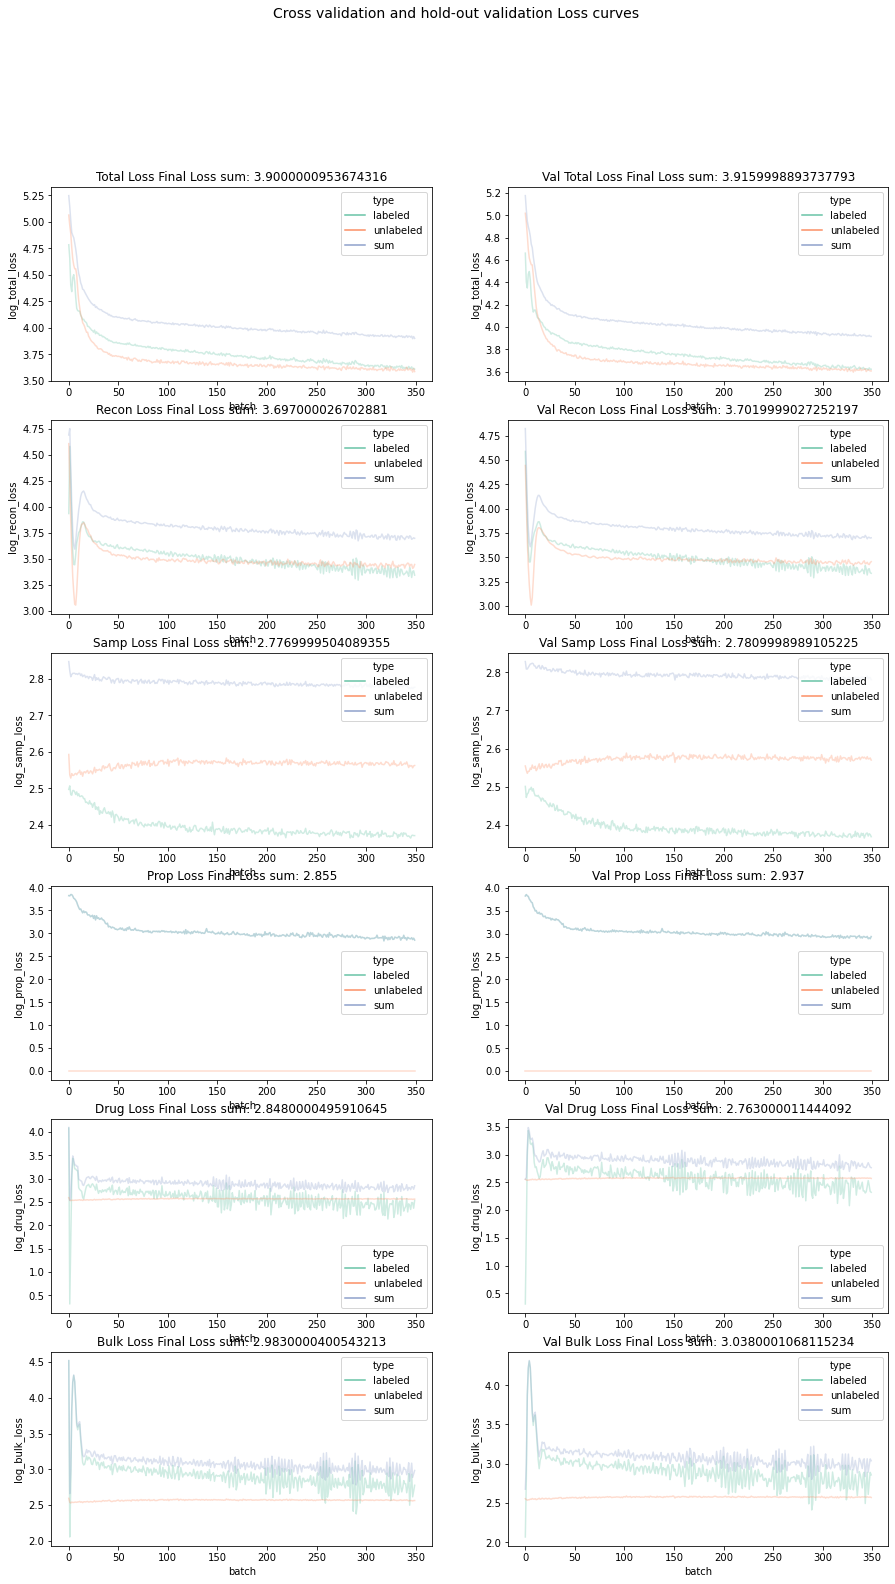

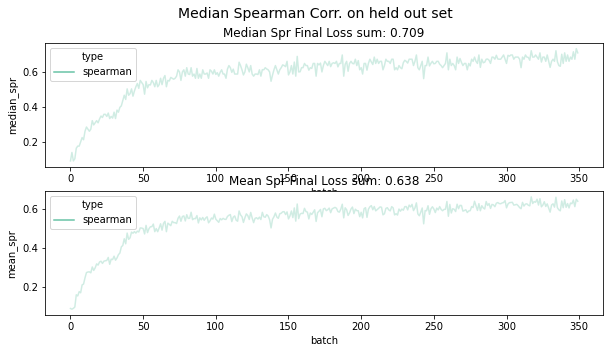

In [69]:
curr_n_epoch=50
curr_wt = 100
params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt, alpha_drug=curr_wt)

curr_exp_id = f"{curr_n_epoch}_{curr_wt}_{exp_id}"
res = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

### 50 1000

test_size_samp: 500
train_size_samp: 3500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  402.5699088573456
Epoch:  49


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_1000_mono-kang_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_1000_mono-kang_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_1000_mono-kang_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_1000_mono-kang_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_1000_mono-kang_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_1000_mono-kang_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_1000_mono-kang_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_1000_mono-kang_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_1000_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_1000_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_1000_mono-kang_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_1000_mono-kang_classifier/assets


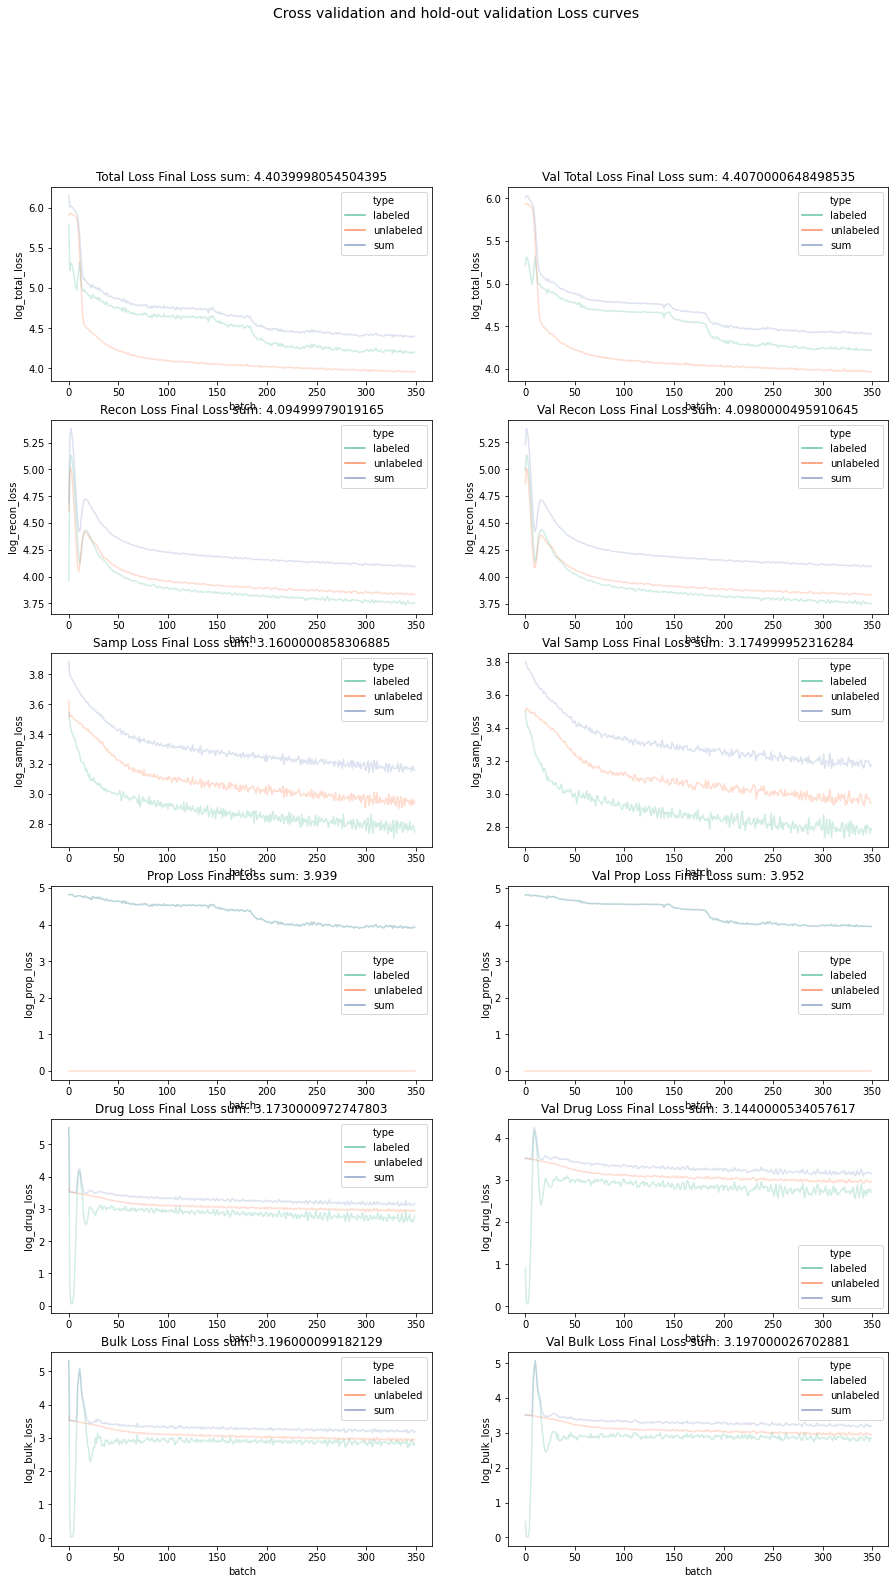

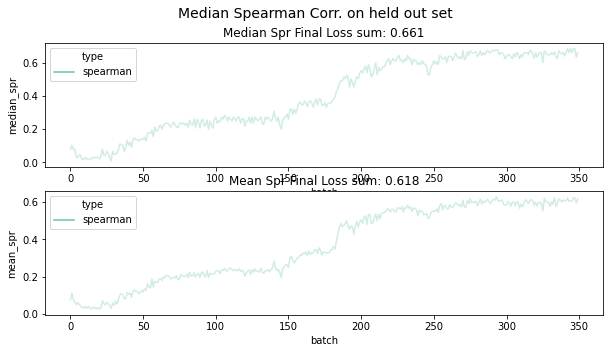

In [71]:
curr_n_epoch=50
curr_wt = 1000
params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt, alpha_drug=curr_wt)

curr_exp_id = f"{curr_n_epoch}_{curr_wt}_{exp_id}"
res = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

### 50 10000

test_size_samp: 500
train_size_samp: 3500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  398.3911690711975
Epoch:  49


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_10000_mono-kang_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_10000_mono-kang_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_10000_mono-kang_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_10000_mono-kang_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_10000_mono-kang_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_10000_mono-kang_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_10000_mono-kang_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_10000_mono-kang_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_10000_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_10000_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_10000_mono-kang_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//50_10000_mono-kang_classifier/assets


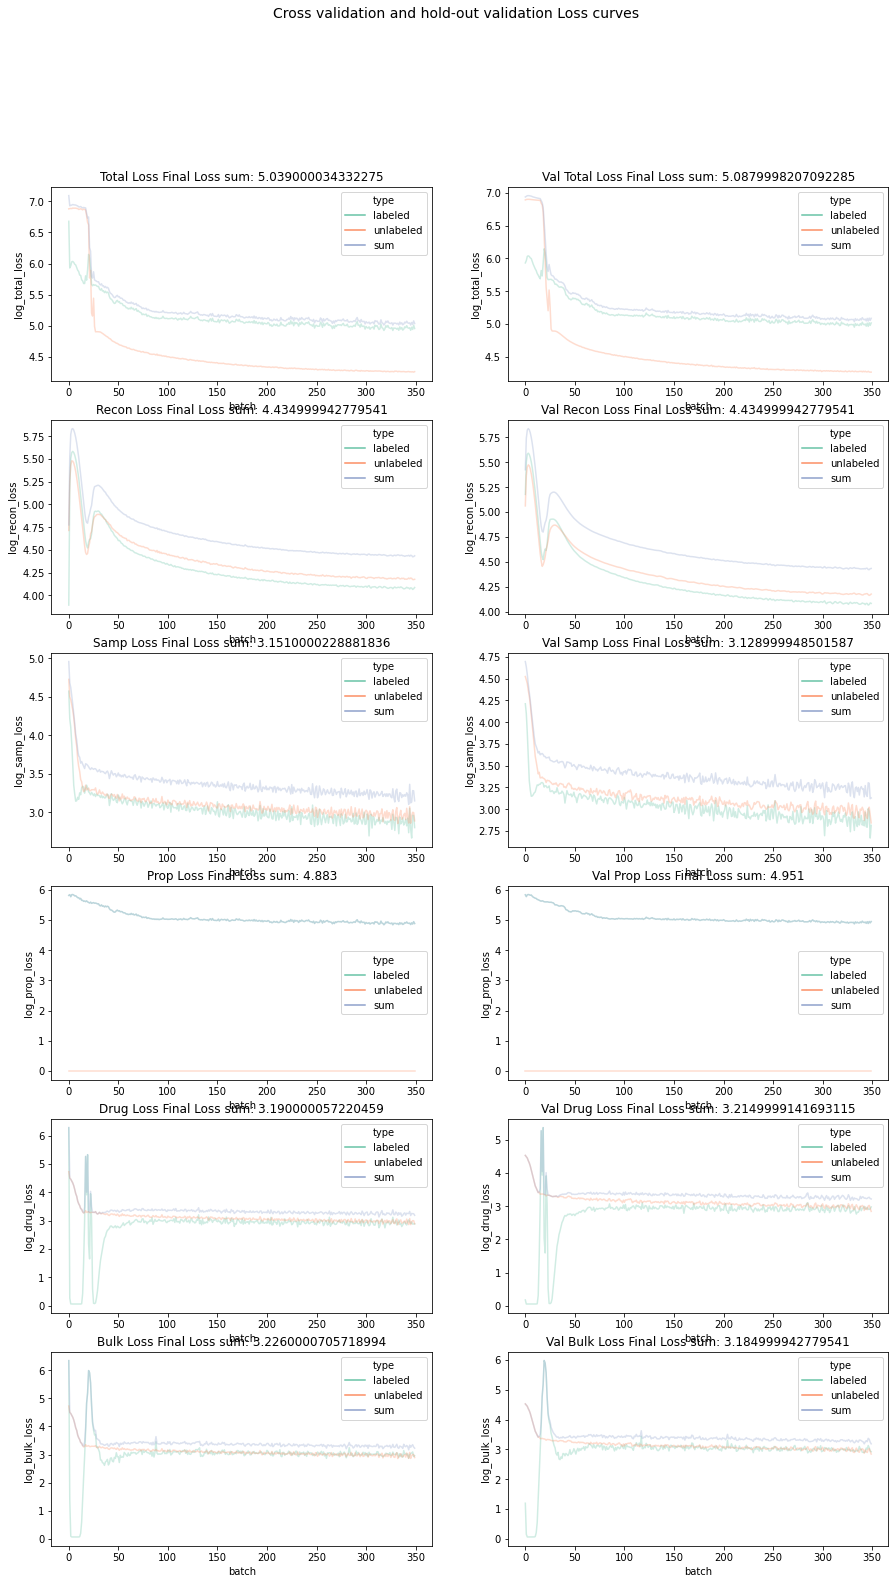

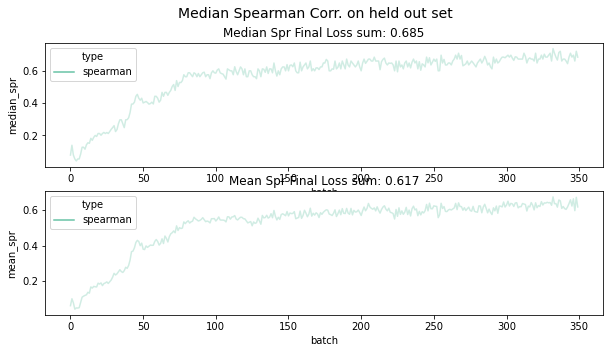

In [72]:
curr_n_epoch=50
curr_wt = 10000
params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt, alpha_drug=curr_wt)

curr_exp_id = f"{curr_n_epoch}_{curr_wt}_{exp_id}"
res = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

### 100 100

test_size_samp: 500
train_size_samp: 3500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  716.3891842365265
Epoch:  99


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_100_mono-kang_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_100_mono-kang_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_100_mono-kang_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_100_mono-kang_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_100_mono-kang_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_100_mono-kang_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_100_mono-kang_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_100_mono-kang_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_100_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_100_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_100_mono-kang_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_100_mono-kang_classifier/assets


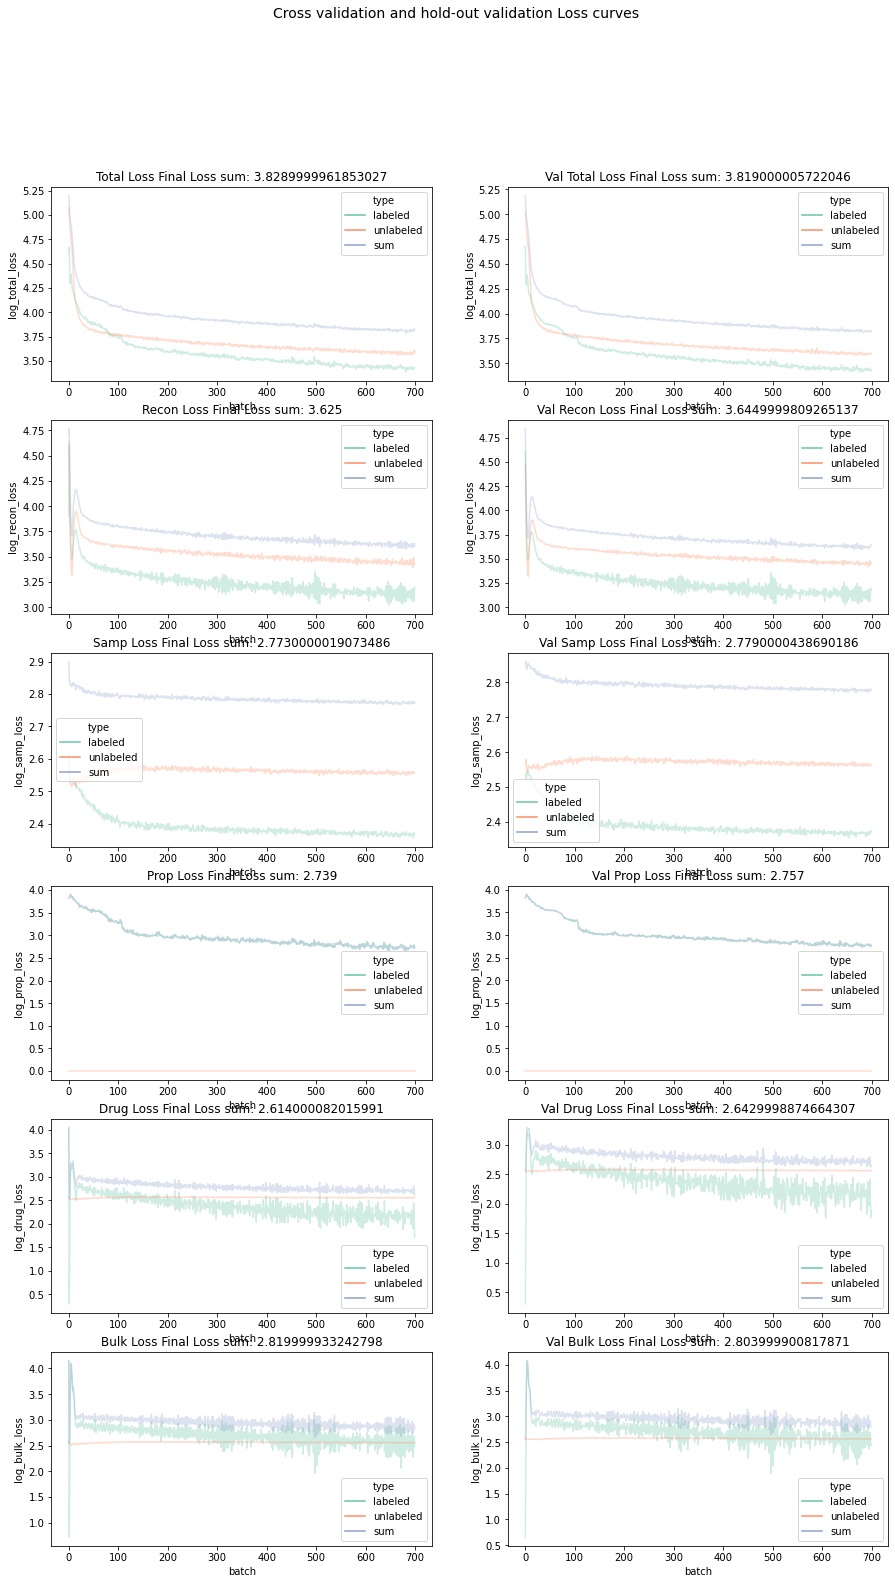

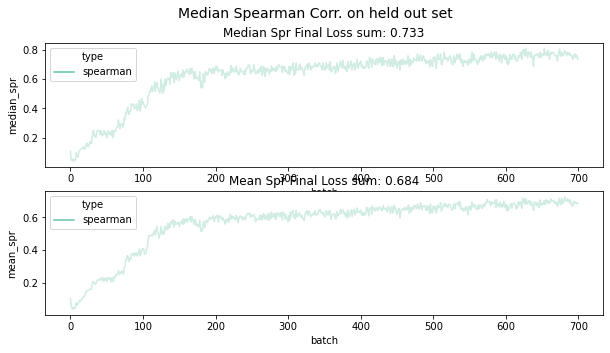

In [73]:
curr_n_epoch=100
curr_wt = 100
params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt, alpha_drug=curr_wt)

curr_exp_id = f"{curr_n_epoch}_{curr_wt}_{exp_id}"
res = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

### 100 1000

test_size_samp: 500
train_size_samp: 3500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  842.6951832771301
Epoch:  99


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_1000_mono-kang_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_1000_mono-kang_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_1000_mono-kang_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_1000_mono-kang_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_1000_mono-kang_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_1000_mono-kang_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_1000_mono-kang_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_1000_mono-kang_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_1000_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_1000_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_1000_mono-kang_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_1000_mono-kang_classifier/assets


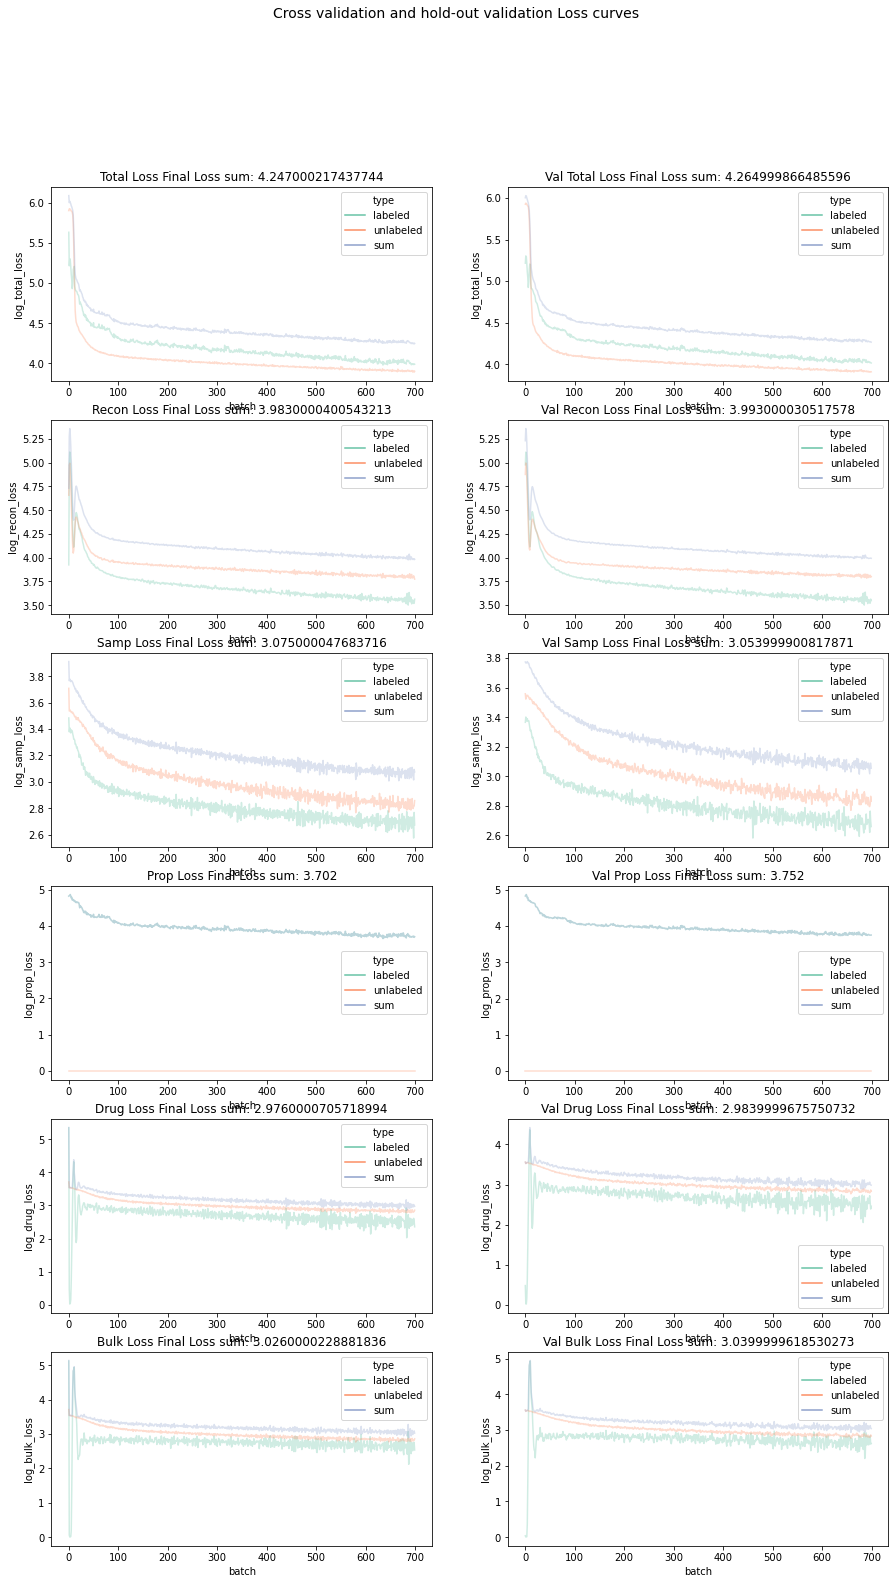

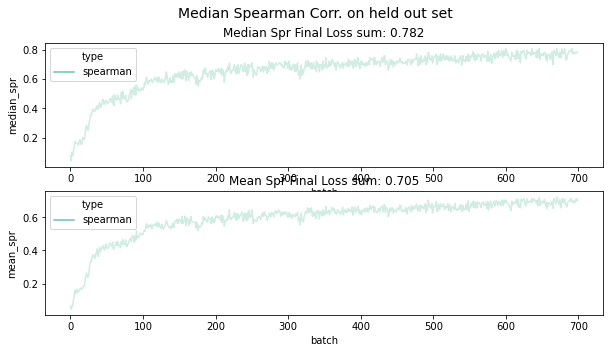

In [74]:
curr_n_epoch=100
curr_wt = 1000
params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt, alpha_drug=curr_wt)

curr_exp_id = f"{curr_n_epoch}_{curr_wt}_{exp_id}"
res = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

### 100 10000

test_size_samp: 500
train_size_samp: 3500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  884.2455196380615
Epoch:  99


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_10000_mono-kang_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_10000_mono-kang_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_10000_mono-kang_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_10000_mono-kang_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_10000_mono-kang_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_10000_mono-kang_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_10000_mono-kang_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_10000_mono-kang_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_10000_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_10000_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_10000_mono-kang_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//100_10000_mono-kang_classifier/assets


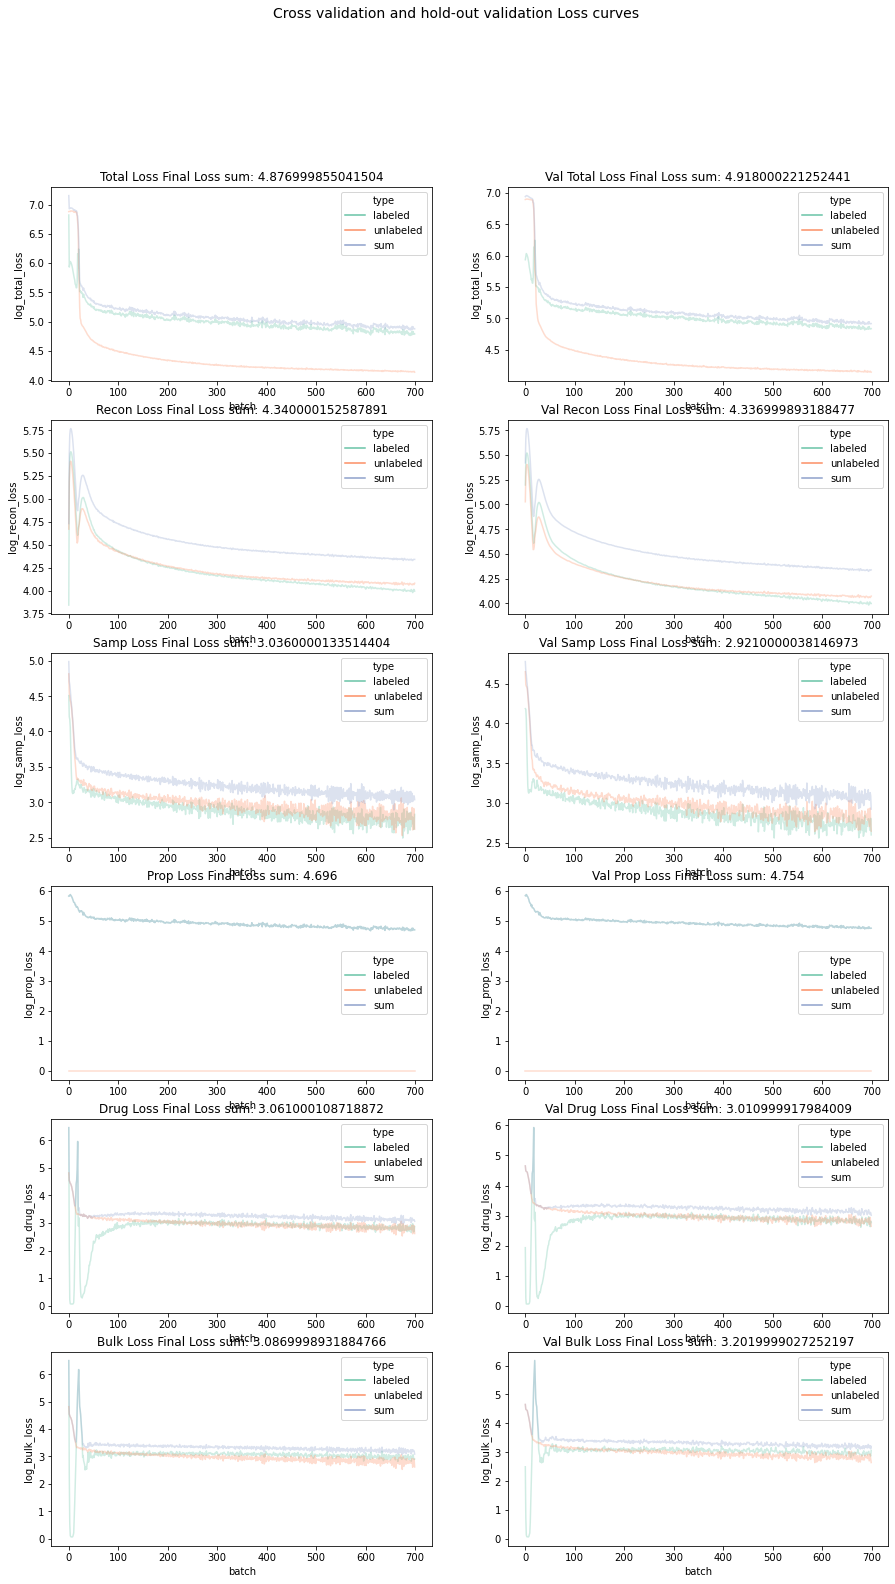

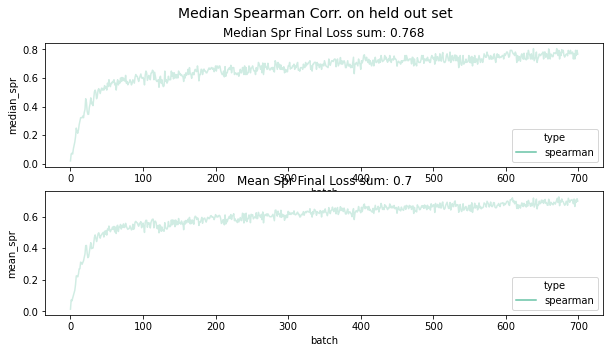

In [75]:
curr_n_epoch=100
curr_wt = 10000
params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
            alpha_rot=curr_wt, alpha_prop=curr_wt, 
            alpha_bulk=curr_wt, alpha_drug=curr_wt)

curr_exp_id = f"{curr_n_epoch}_{curr_wt}_{exp_id}"
res = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
            n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
            X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
            X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

# **Results**

Looking at all the results, we see that XX performs the best overall, from the spearman correlation and from the validation loss. We will go forward with these hyperparameters and run them three times to get 3 different trained models that we can use for downstream validation.

test_size_samp: 500
train_size_samp: 3500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  889.0059194564819
Epoch:  99


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model1_mono-kang_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model1_mono-kang_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model1_mono-kang_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model1_mono-kang_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model1_mono-kang_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model1_mono-kang_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model1_mono-kang_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model1_mono-kang_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model1_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model1_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model1_mono-kang_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model1_mono-kang_classifier/assets


test_size_samp: 500
train_size_samp: 3500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  892.5527336597443
Epoch:  99


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model2_mono-kang_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model2_mono-kang_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model2_mono-kang_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model2_mono-kang_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model2_mono-kang_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model2_mono-kang_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model2_mono-kang_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model2_mono-kang_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model2_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model2_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model2_mono-kang_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model2_mono-kang_classifier/assets


test_size_samp: 500
train_size_samp: 3500


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:  901.178676366806
Epoch:  99


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model3_mono-kang_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model3_mono-kang_known_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model3_mono-kang_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model3_mono-kang_unknown_prop_vae/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model3_mono-kang_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model3_mono-kang_encoder_unlab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model3_mono-kang_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model3_mono-kang_encoder_lab/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model3_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model3_mono-kang_decoder/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model3_mono-kang_classifier/assets


INFO:tensorflow:Assets written to: /beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../results/single_cell_data/buddiM2_kang//model3_mono-kang_classifier/assets


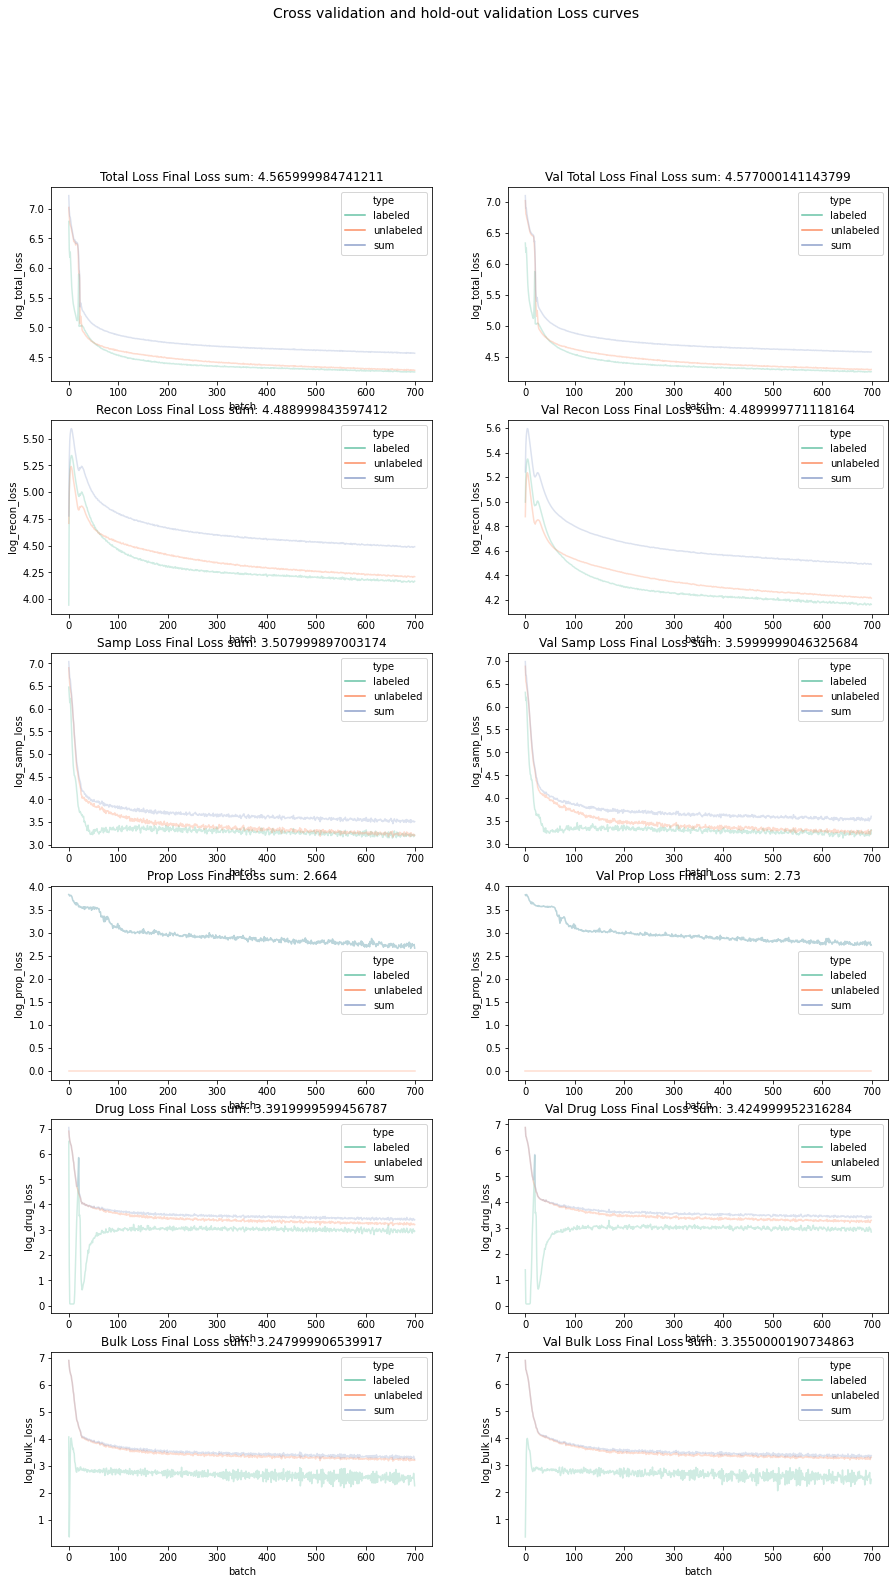

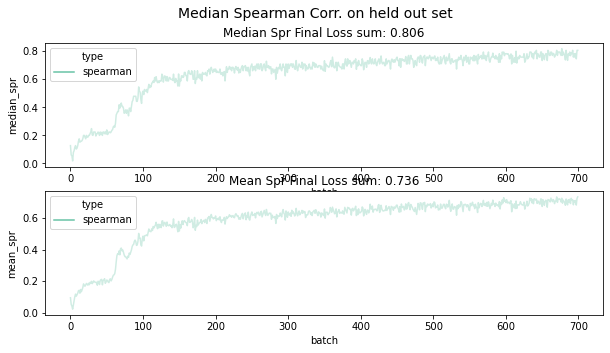

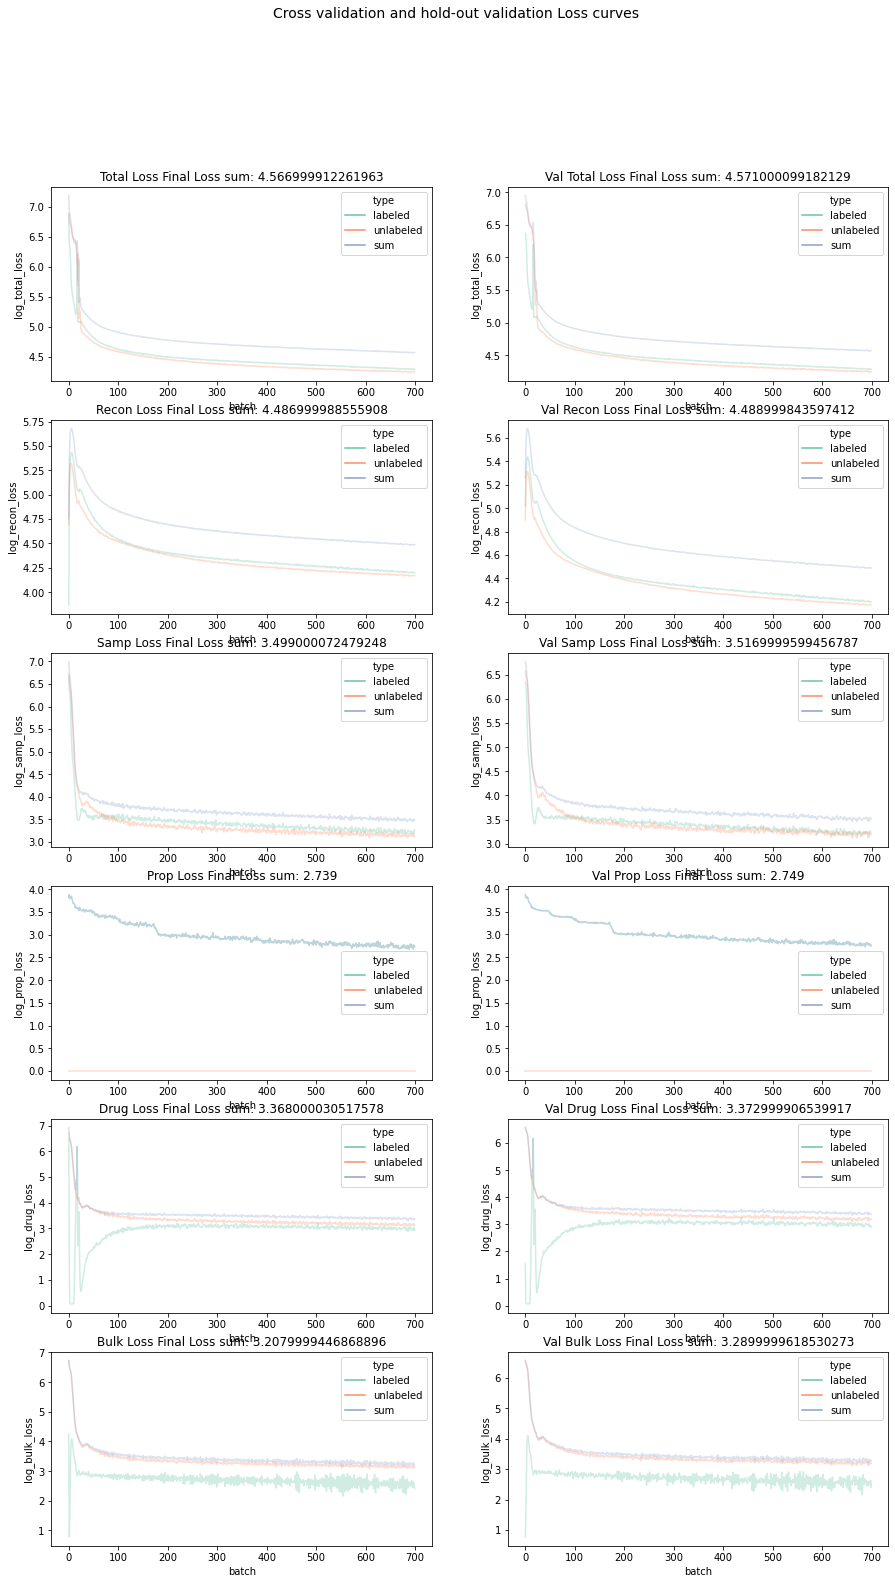

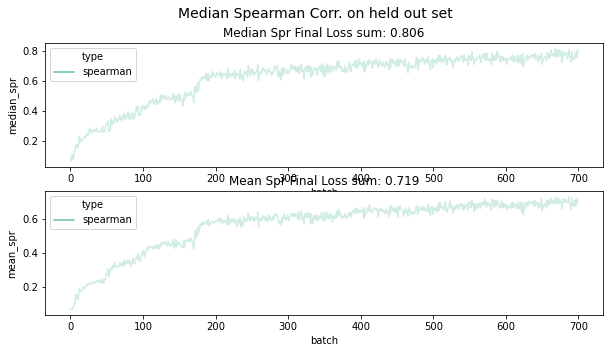

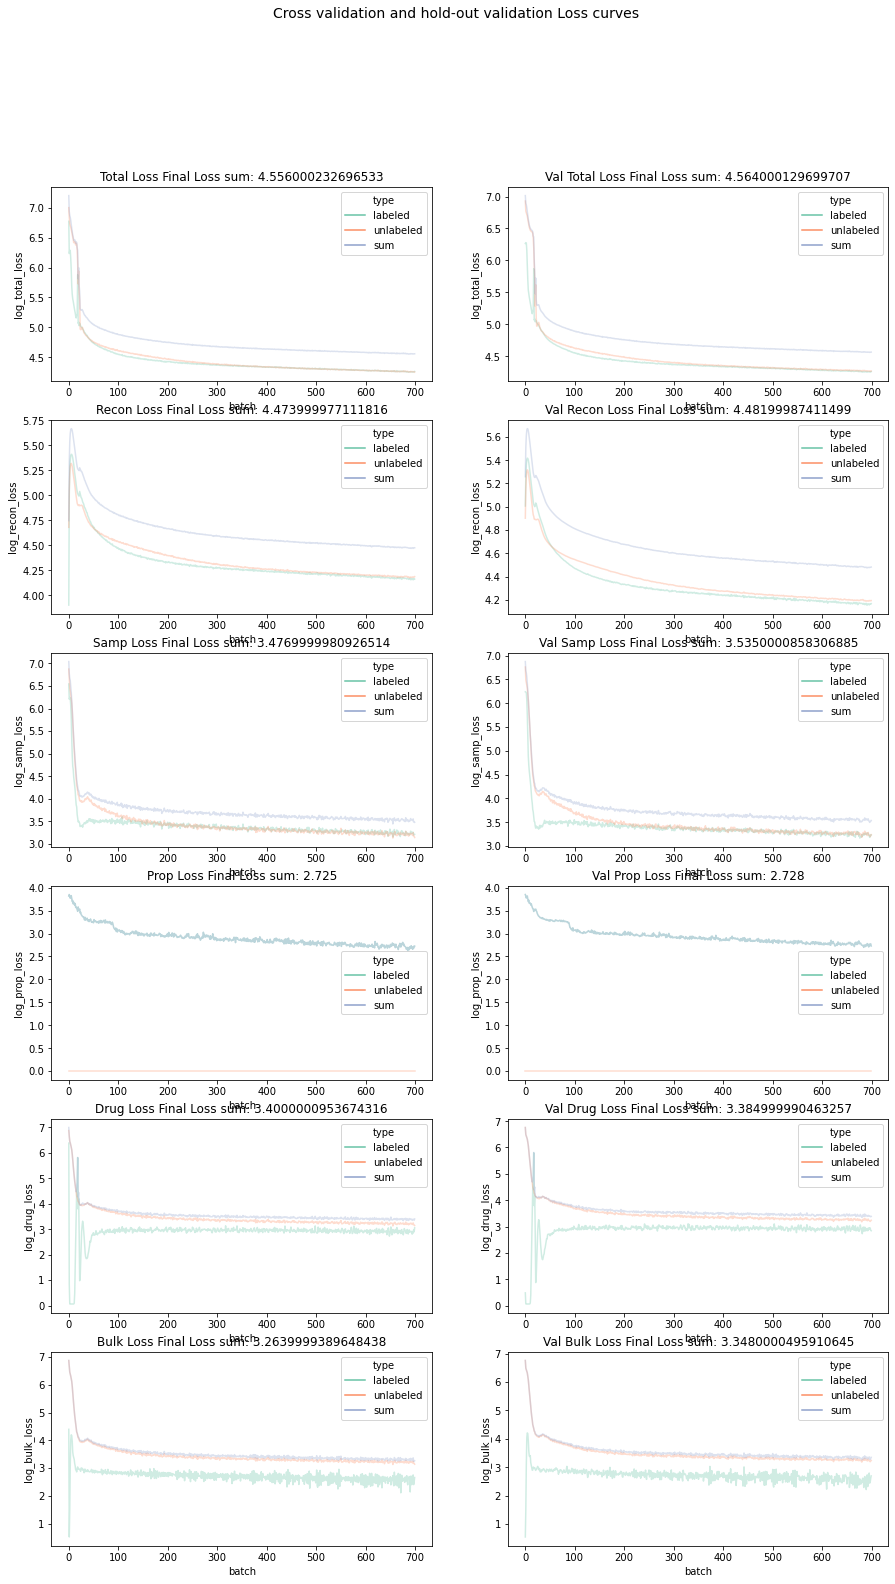

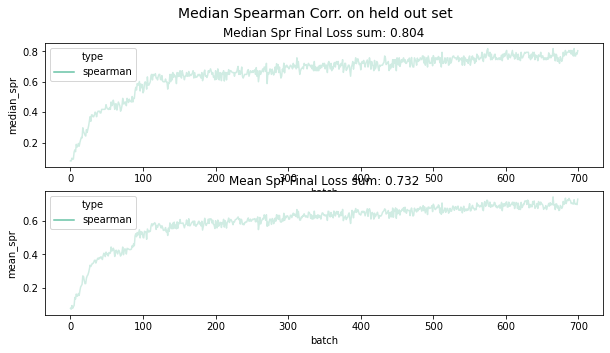

In [129]:
curr_n_epoch=100
curr_wt = 1000


if True: # RETRAIN_MODELS


    params = buddi.BuddiTrainParameters(n_epoch=curr_n_epoch, 
                alpha_rot=1000000, alpha_prop=100, 
                alpha_bulk=100, alpha_drug=10000)

    ## model 1
    curr_exp_id = f"model1_{exp_id}"
    res1 = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
                n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
                X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
                X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

    ## model 2
    curr_exp_id = f"model2_{exp_id}"
    res2 = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
                n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
                X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
                X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)

    ## model 3
    curr_exp_id = f"model3_{exp_id}"
    res3 = buddi.train_buddi(res_data_path, curr_exp_id, use_buddi4=True, 
                n_tot_samples=n_tot_samples, n_drugs=n_drugs, n_tech=n_tech, 
                X_unkp=X_unkp, label_unkp=label_unkp, drug_unkp=drug_unkp, bulk_unkp=bulk_unkp,
                X_kp=X_kp, y_kp=y_kp, label_kp=label_kp, drug_kp=drug_kp, bulk_kp=bulk_kp, params=params)


res1_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model1_{exp_id}_encoder_unlab")
res1_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model1_{exp_id}_encoder_lab")
res1_dec = tf.keras.models.load_model(f"{res_data_path}/model1_{exp_id}_decoder")
res1_classifier = tf.keras.models.load_model(f"{res_data_path}/model1_{exp_id}_classifier")


res2_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model2_{exp_id}_encoder_unlab")
res2_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model2_{exp_id}_encoder_lab")
res2_dec = tf.keras.models.load_model(f"{res_data_path}/model2_{exp_id}_decoder")
res2_classifier = tf.keras.models.load_model(f"{res_data_path}/model2_{exp_id}_classifier")


res3_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model3_{exp_id}_encoder_unlab")
res3_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model3_{exp_id}_encoder_lab")
res3_dec = tf.keras.models.load_model(f"{res_data_path}/model3_{exp_id}_decoder")
res3_classifier = tf.keras.models.load_model(f"{res_data_path}/model3_{exp_id}_classifier")

## visualize latent spaces

### subset data

In [130]:
# subset the data to the training data
# to show our latent spaces are learning appropriately

idx_tmp_bulk = np.where(np.logical_and(meta_df.isTraining == "Train", meta_df.cell_prop_type == "realistic"))[0]
idx_tmp_bulk = np.random.choice(idx_tmp_bulk, 5000, replace=True)

idx_tmp = np.where(np.logical_and(meta_df.isTraining == "Train", meta_df.cell_prop_type != "realistic"))[0]
idx_tmp = np.random.choice(idx_tmp, 5000, replace=True)
idx_tmp = np.concatenate((idx_tmp, idx_tmp_bulk))

#idx_tmp_bulk = np.where(meta_df.isTraining == "Train")[0]
#idx_tmp = np.random.choice(idx_tmp, 10000, replace=True)


X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
Y_temp = Y_full.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


bulk_temp =np.copy(Bulk_full)
bulk_temp = bulk_temp[idx_tmp]


### plot data

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)


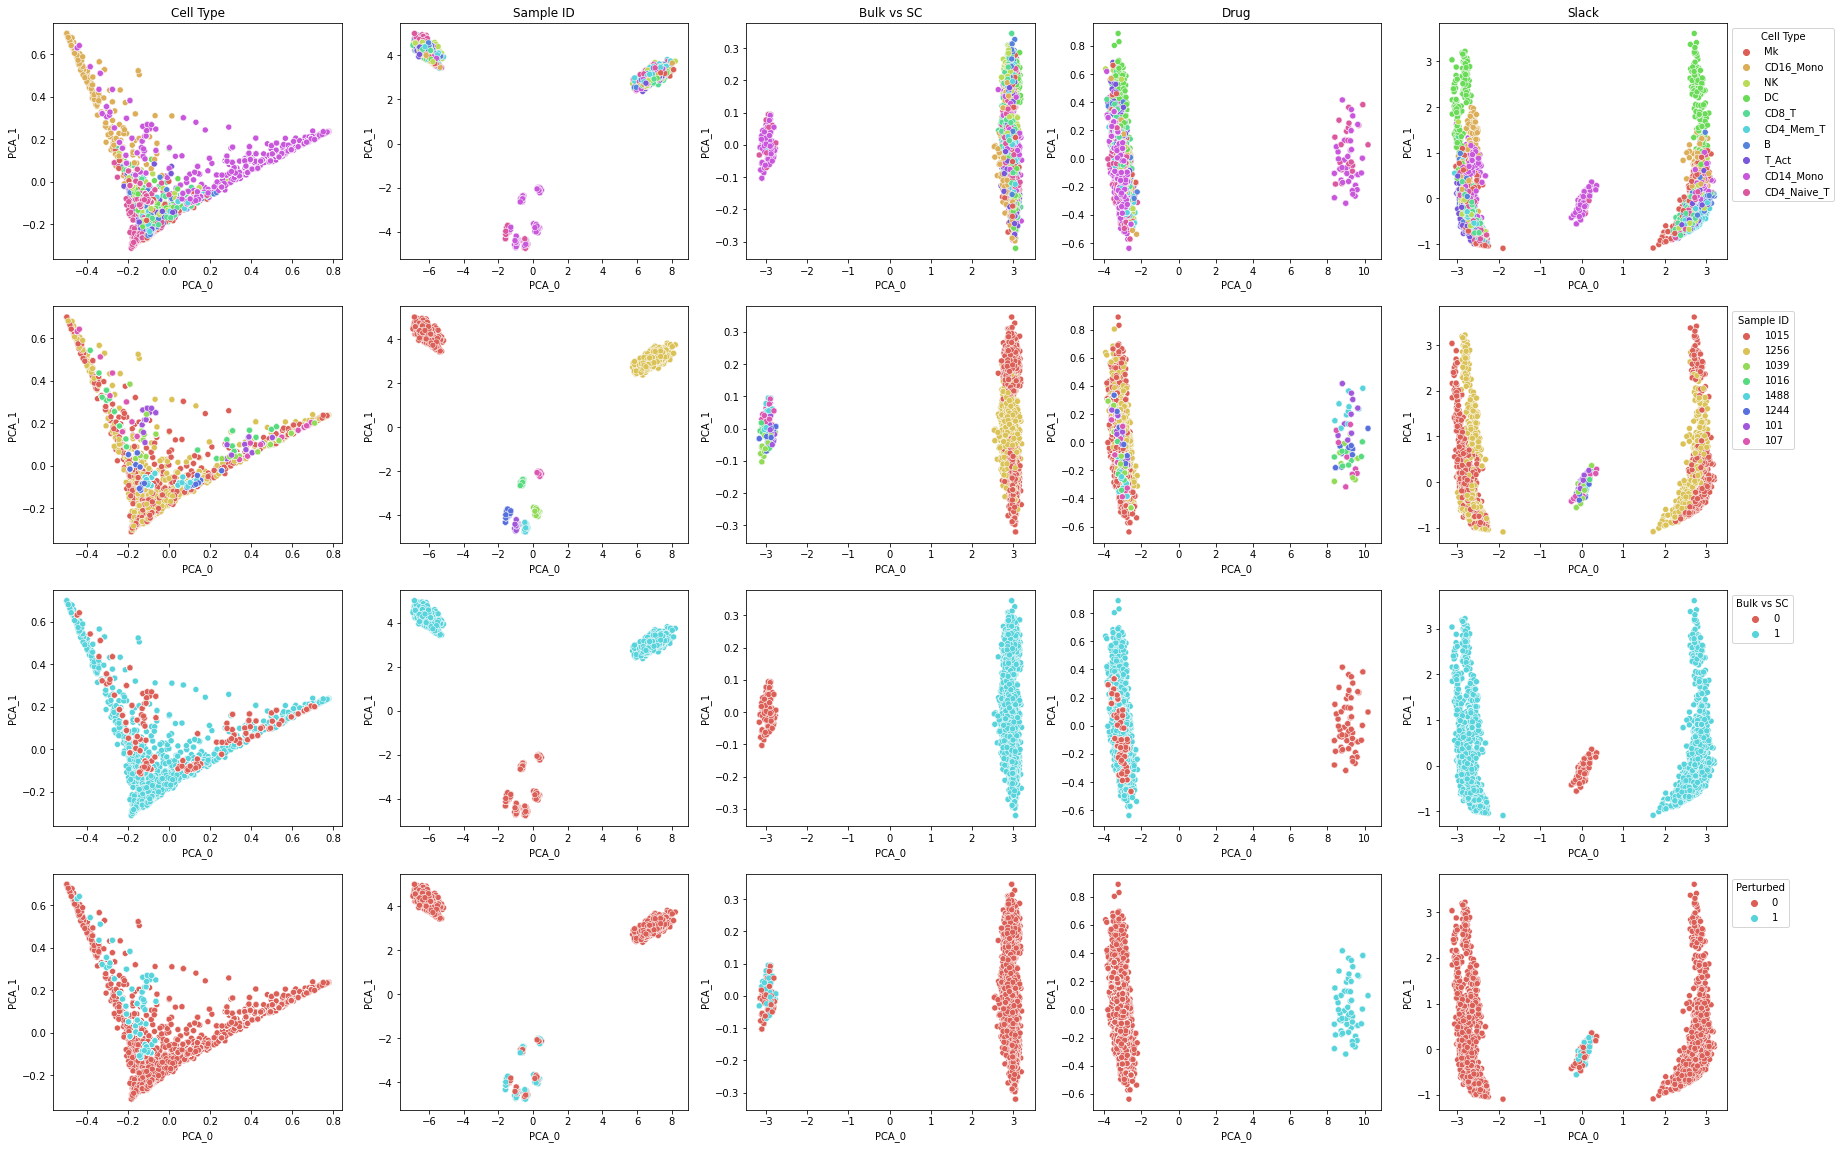

In [131]:

res1_latent_plot = buddi.plot_latent_spaces(res1_enc_unlab, res1_classifier,
                        X_temp, Y_temp, label_temp, perturb_temp, bulk_temp, 
                        batch_size=500, use_buddi4=True)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)


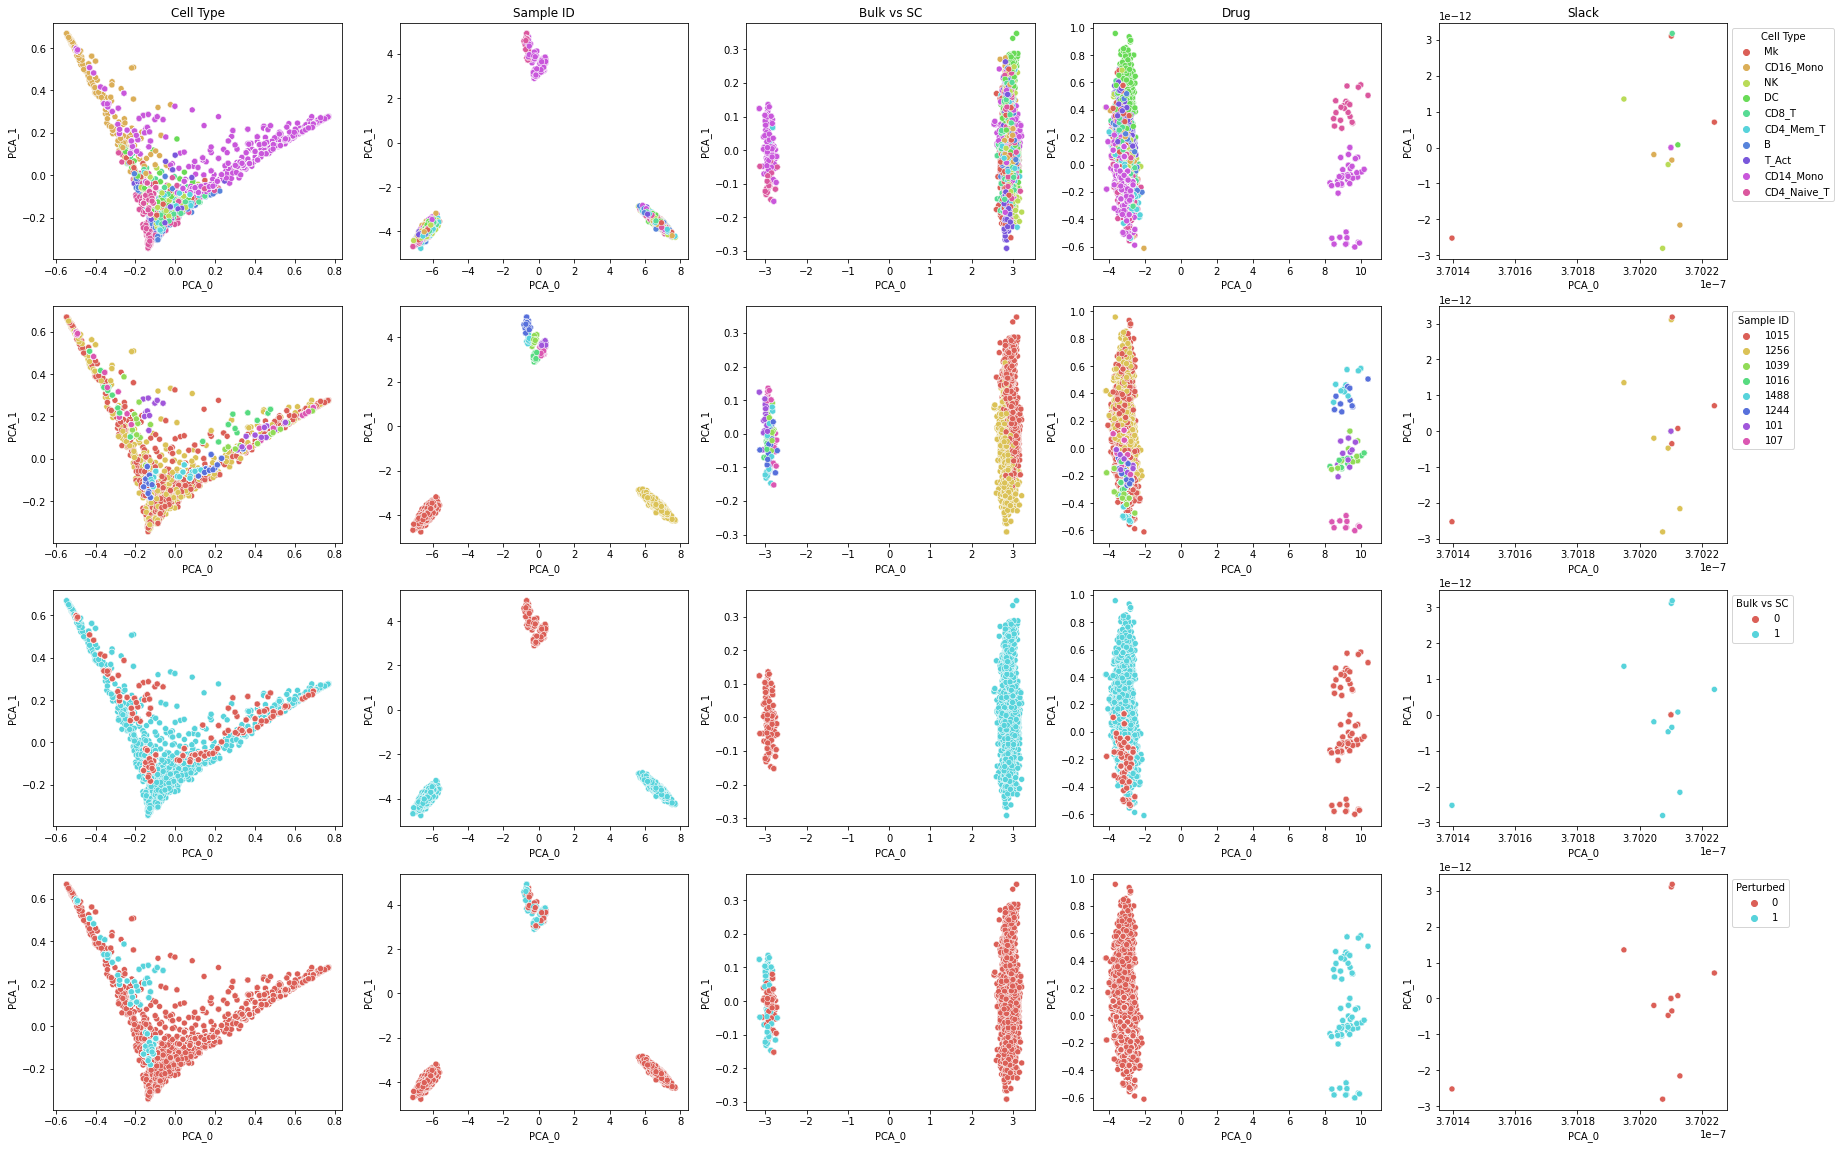

In [132]:

res2_latent_plot = buddi.plot_latent_spaces(res2_enc_unlab, res2_classifier,
                        X_temp, Y_temp, label_temp, perturb_temp, bulk_temp, 
                        batch_size=500, use_buddi4=True)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:595: RuntimeWarning: divide by zero encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()


(10000, 2)
(10000, 2)


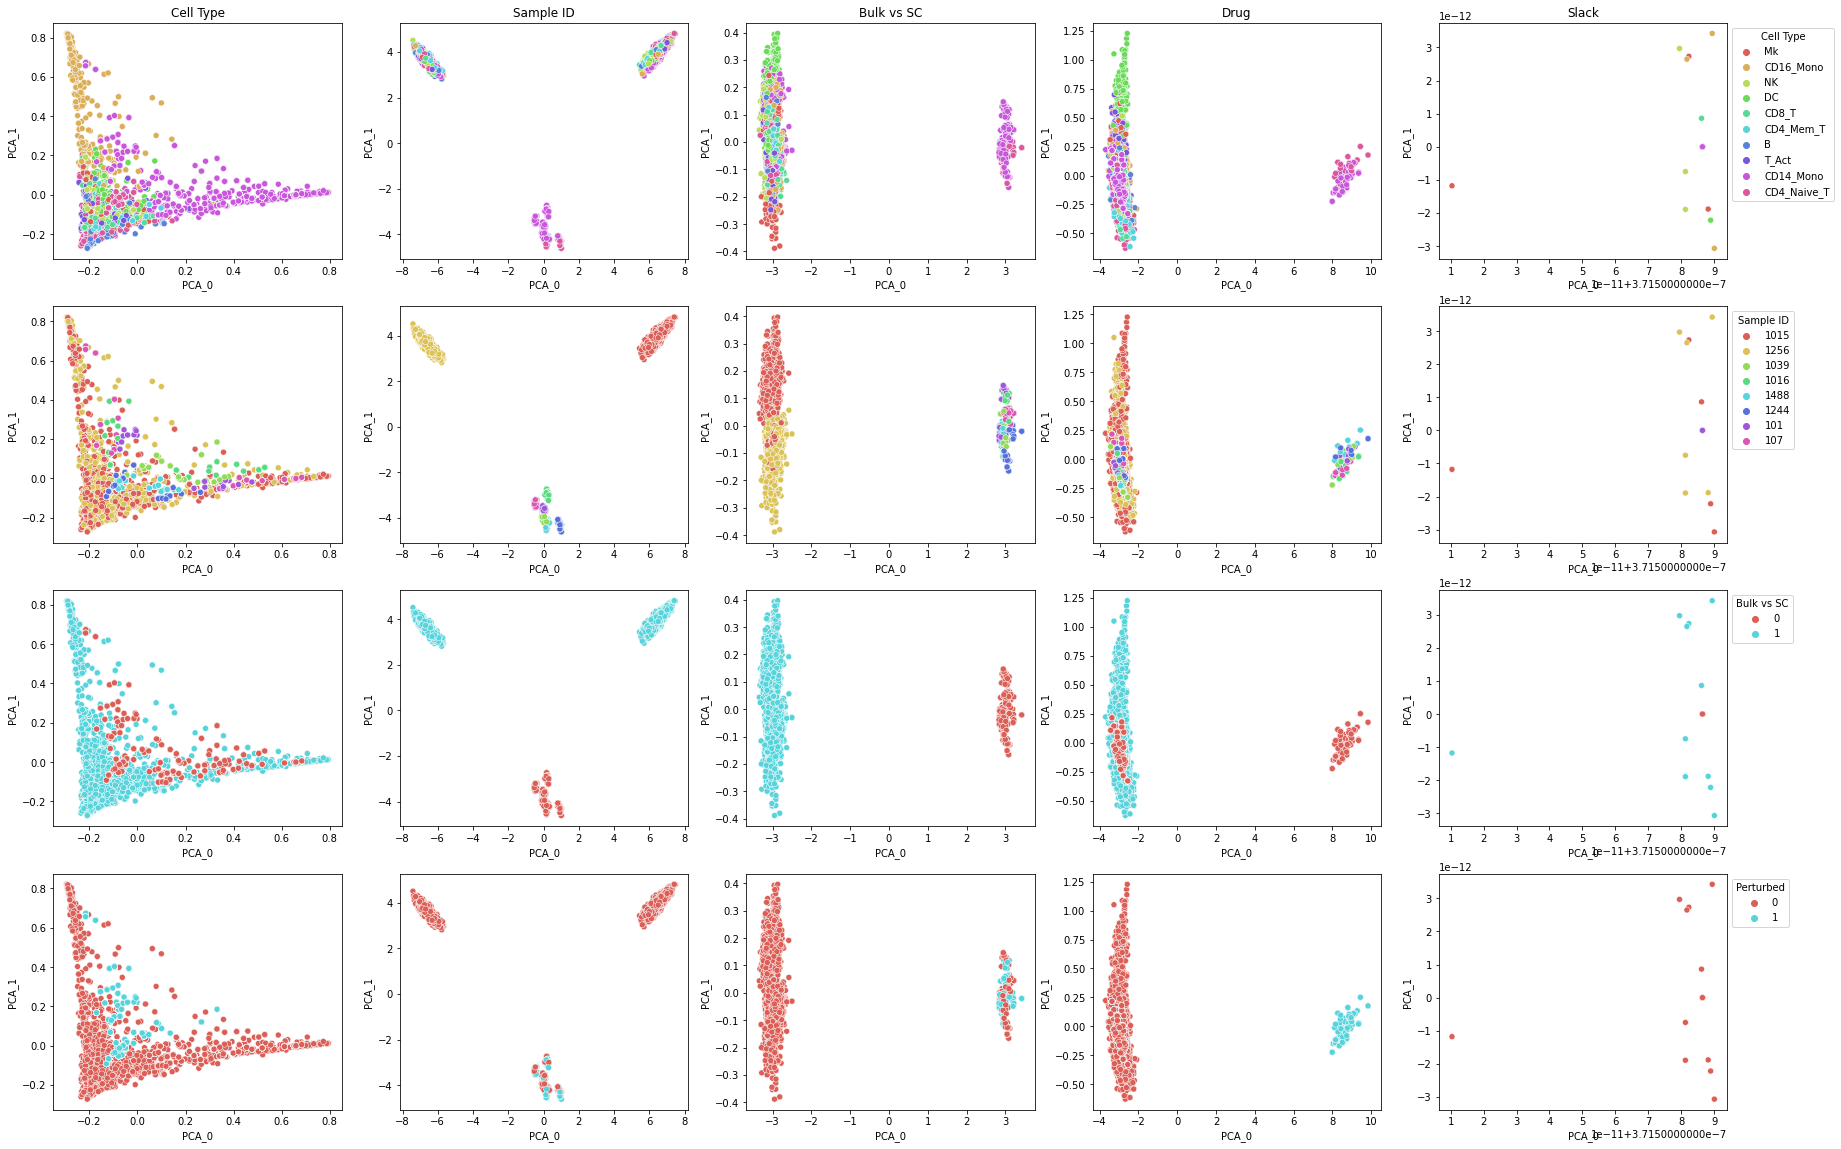

In [133]:

res3_latent_plot = buddi.plot_latent_spaces(res3_enc_unlab, res3_classifier,
                        X_temp, Y_temp, label_temp, perturb_temp, bulk_temp, 
                        batch_size=500, use_buddi4=True)

## visualize reconstruction

### subset data

In [134]:
# take all training data
recon_idx = np.where(np.logical_and(meta_df.cell_prop_type == "cell_type_specific", meta_df.isTraining == "Test"))[0]
recon_idx = np.where(recon_idx)[0]
recon_idx = np.random.choice(recon_idx, 5000, replace=True)

# subset our data

meta_temp = meta_df.iloc[recon_idx]

X_temp = np.copy(X_full[recon_idx])

Y_temp = np.copy(Y_full.iloc[recon_idx])
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_full.columns[Y_temp]


label_temp = np.copy(Label_full[recon_idx])
label_temp = index_label[label_temp]

perturb_temp = Drug_full[recon_idx]




### plot data

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(10000, 2)
(10000, 2)


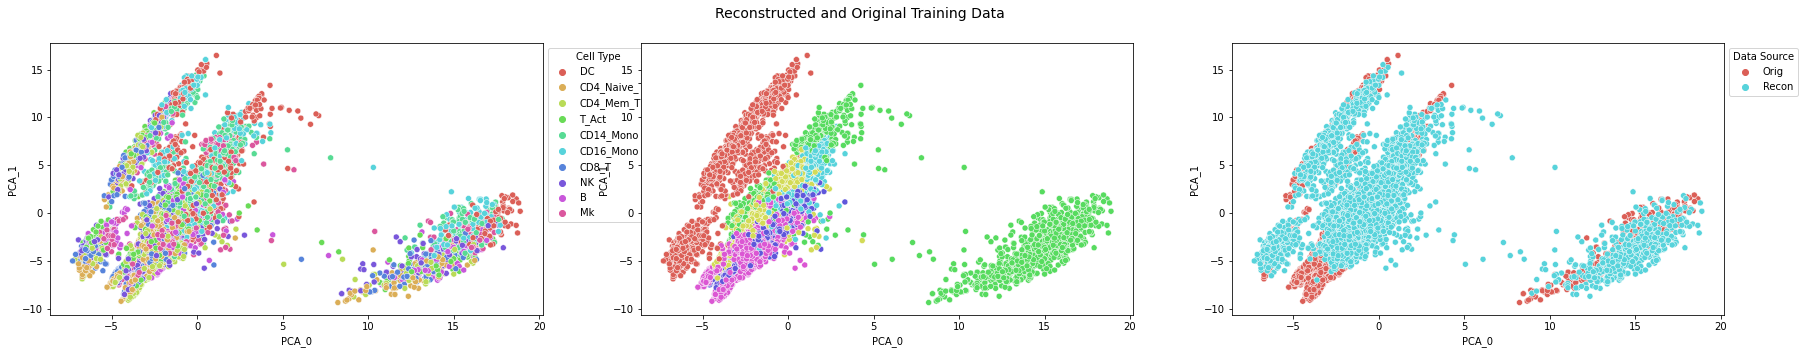

In [135]:
res1_recon_plot = buddi.plot_reconstruction_buddi(res1_enc_unlab, res1_classifier, res1_dec, 
        X_temp, Y_temp, label_temp, perturb_temp, 
        batch_size=500, use_buddi4=True)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(10000, 2)
(10000, 2)


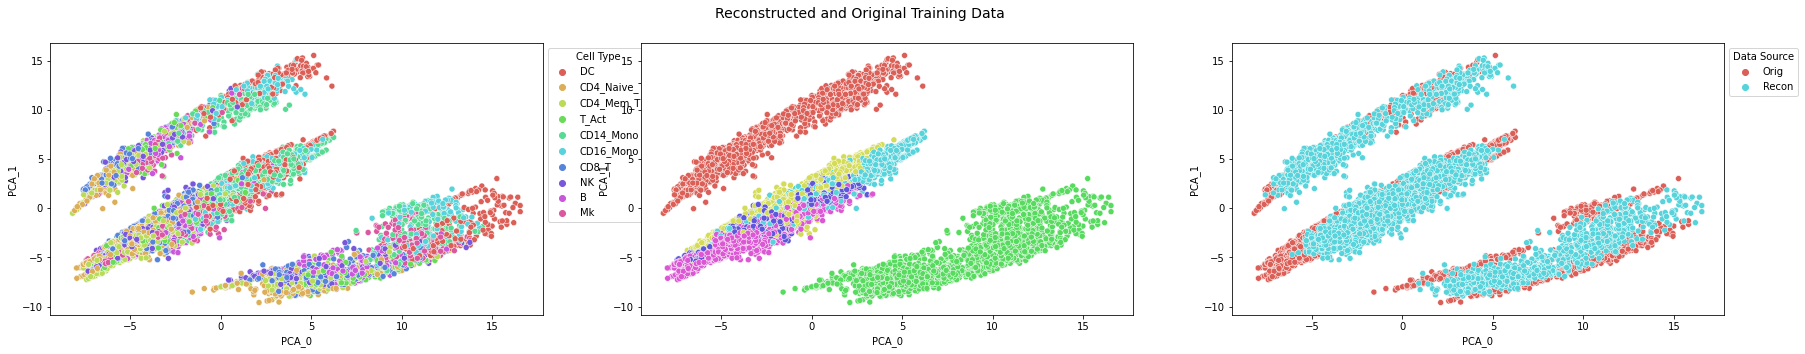

In [136]:
res2_recon_plot = buddi.plot_reconstruction_buddi(res2_enc_unlab, res2_classifier, res2_dec, 
        X_temp, Y_temp, label_temp, perturb_temp, 
        batch_size=500, use_buddi4=True)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(10000, 2)
(10000, 2)


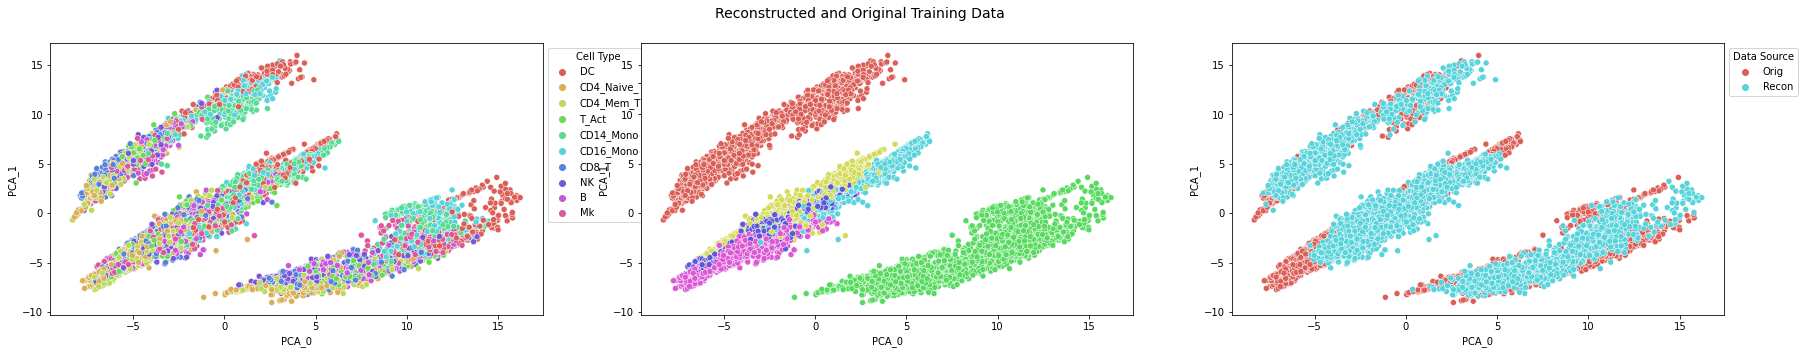

In [137]:
res3_recon_plot = buddi.plot_reconstruction_buddi(res3_enc_unlab, res3_classifier, res3_dec, 
        X_temp, Y_temp, label_temp, perturb_temp, 
        batch_size=500, use_buddi4=True)